# Sad songs<a name="top"></a>

This is a replication of the [fitteR happieR](http://rcharlie.com/2017-02-16-fitteR-happieR/) post which attempted to find the most depressing Radiohead song.

I've redone it here, using tools available in TM351.

I'm also on a bit of a Beatles jag, so I've also done the analysis for Beatles songs.

## Contents
### Data gathering

* [Getting data from Spotify](#getspotify)
* [Tag album with artist](#tagalbumwithartist)
* [Tag track with artist](#tagtrackwithartist)
* [Get full track data](#fulltrackdata)
* [Lyrics search](#lyricssearch)
* [Matching datasets](#matchingdatasets)
* [Copy the lyrics over](#copylyrics)
* [Sentiment analysis](#sentimentanalysis)

### Data analysis
* [Analysis](#analysis)
* [Sentiment](#sentiment)
* [Gloom index](#gloomindex)
* [Revised gloom index](#revisedgloomindex)
* [Contrasting songs](#valencenegcontrast)
* [Gloom per album](#gloomperalbum)
* [Complexity per album](#complexityovertime)

### [Conclusion](#conclusion)

In [323]:
import pandas as pd
import numpy as np
import urllib.request
import urllib.parse
import urllib.error
import json
import base64
import configparser
from bs4 import BeautifulSoup
import re
import pymongo
from datetime import datetime
import time
import collections

We'll use MongoDB to store the data, to save keeping it all in memory, and mean we don't have to recapture all the data to to a different analysis.

In [2]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27351/')

In [6]:
try:
    client.drop_database(songs_db)
except NameError:
    print("DB doesn't exist yet.")

In [7]:
# Create a database and a collections within it.
songs_db = client.songs
albums = songs_db.albums
tracks = songs_db.tracks
genius_tracks = songs_db.gtracks

API keys and the like are kept in a configuration file, which is read here.

You'll need to create a web API key for Spotify and Genius. 

In [8]:
config = configparser.ConfigParser()
config.read('secrets.ini')
[k for k in config['genius']]

['app_name', 'client_id', 'client_secret', 'redirect_uri', 'token']

In [385]:
## How to write the config file. Fill in the details, and create a different config section for Spotify.
# config['genius'] = {}
# config['genius']['app_name'] = 'xxx'
# config['genius']['client_id'] = 'xxx'
# config['genius']['client_secret'] = 'xxx'
# config['genius']['token'] = 'xxx'
# with open('secrets.ini', 'w') as configfile:
#     config.write(configfile)

# Get album and track data from Spotify<a name='getspotify'></a>
We'll download the data on artists, albums, and tracks from Spotify.

* [Top](#top)

In [9]:
def get_artists(artist_name):
    query = urllib.parse.urlencode({'q': artist_name, 'type': 'artist'})
    request = 'https://api.spotify.com/v1/search?{}'.format(query)
    with urllib.request.urlopen(request) as f:
        response = json.loads(f.read().decode('utf-8'))
        artists = []
        for artist in response['artists']['items']:
            if artist['name'].lower() == artist_name.lower():
                this_artist = {'name': artist['name'], 'id': artist['id']}
                if artist['images']:
                    this_artist['image'] = artist['images'][0]['url']
                artists += [this_artist]
    return artists

In [67]:
artists = get_artists('radiohead')
radiohead_id = artists[0]['id']
radiohead_id, artists

('4Z8W4fKeB5YxbusRsdQVPb',
 [{'id': '4Z8W4fKeB5YxbusRsdQVPb',
   'image': 'https://i.scdn.co/image/afcd616e1ef2d2786f47b3b4a8a6aeea24a72adc',
   'name': 'Radiohead'}])

In [68]:
artists = get_artists('the beatles')
beatles_id = artists[0]['id']
beatles_id, artists

('3WrFJ7ztbogyGnTHbHJFl2',
 [{'id': '3WrFJ7ztbogyGnTHbHJFl2',
   'image': 'https://i.scdn.co/image/934c57df9fbdbbaa5e93b55994a4cb9571fd2085',
   'name': 'The Beatles'}])

Find all the albums for an artist.

In [19]:
def get_albums(artist_id):
        request = 'https://api.spotify.com/v1/artists/{id}/albums?market=GB&album_type=album'.format(id=artist_id)
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            for a in response['items']:
                album_request = a['href']
                with urllib.request.urlopen(album_request) as af:
                    album = json.loads(af.read().decode('utf-8'))
                    album['_id'] = album['id']
                    albums.replace_one({'_id': album['_id']}, album, upsert=True)

In [20]:
get_albums(beatles_id)
albums.find().count()

15

In [86]:
get_albums(radiohead_id)
albums.find().count()

28

In [21]:
albums.find_one({'_id': '2pCqZLeavM2BMovJXsJEIV'})

{'_id': '2pCqZLeavM2BMovJXsJEIV',
 'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
   'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
   'id': '3WrFJ7ztbogyGnTHbHJFl2',
   'name': 'The Beatles',
   'type': 'artist',
   'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
 'available_markets': ['AD',
  'AR',
  'AT',
  'AU',
  'BE',
  'BG',
  'BO',
  'BR',
  'CH',
  'CL',
  'CO',
  'CR',
  'CY',
  'CZ',
  'DE',
  'DK',
  'DO',
  'EC',
  'EE',
  'ES',
  'FI',
  'FR',
  'GB',
  'GR',
  'GT',
  'HK',
  'HN',
  'HU',
  'ID',
  'IE',
  'IS',
  'IT',
  'JP',
  'LI',
  'LT',
  'LU',
  'LV',
  'MC',
  'MT',
  'MY',
  'NI',
  'NL',
  'NO',
  'NZ',
  'PA',
  'PE',
  'PH',
  'PL',
  'PT',
  'PY',
  'SE',
  'SG',
  'SK',
  'SV',
  'TR',
  'TW',
  'UY'],
 'copyrights': [{'text': '(C) 2015 Apple Corps Ltd', 'type': 'C'},
  {'text': '(P) 2015 Calderstone Productions Limited (a division of Universal Music Grou

In [22]:
albums.find_one({'_id': '6P9yO0ukhOx3dvmhGKeYoC'})

{'_id': '6P9yO0ukhOx3dvmhGKeYoC',
 'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
   'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
   'id': '3WrFJ7ztbogyGnTHbHJFl2',
   'name': 'The Beatles',
   'type': 'artist',
   'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
 'available_markets': ['AD',
  'AR',
  'AT',
  'AU',
  'BE',
  'BG',
  'BO',
  'BR',
  'CH',
  'CL',
  'CO',
  'CR',
  'CY',
  'CZ',
  'DE',
  'DK',
  'DO',
  'EC',
  'EE',
  'ES',
  'FI',
  'FR',
  'GB',
  'GR',
  'GT',
  'HK',
  'HN',
  'HU',
  'ID',
  'IE',
  'IS',
  'IT',
  'JP',
  'LI',
  'LT',
  'LU',
  'LV',
  'MC',
  'MT',
  'MY',
  'NI',
  'NL',
  'NO',
  'NZ',
  'PA',
  'PE',
  'PH',
  'PL',
  'PT',
  'PY',
  'SE',
  'SG',
  'SK',
  'SV',
  'TR',
  'TW',
  'UY'],
 'copyrights': [{'text': '(C) 2015 Apple Corps Ltd', 'type': 'C'},
  {'text': '(P) 2015 Calderstone Productions Limited (a division of Universal Music Grou

### Tag albums with artists<a name="tagalbumwithartist"></a>
As we have tracks for two artists, let's keep the identification easy.

* [Top](#top)

In [93]:
for a in albums.find({}, ['artists']):
    albums.update_one({'_id': a['_id']}, 
                      {'$set': {'artist_name': a['artists'][0]['name'],
                                'artist_id': a['artists'][0]['id']}})

In [94]:
pd.DataFrame(list(albums.find({}, ['name', 'artist_name'])))

,_id,artist_name,name
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered)
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered)
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered)
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered)
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered)
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered)
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered)
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered)


According to the [Spotify documentation](https://developer.spotify.com/web-api/object-model/#track-object), some objects returned have only a bit of the data, and contain a `href` field for where to find the rest. The track details in the album documents fit that bill, so let's find the full track information.

While doing this, not that Spotify will rate-limit the requests, so we have to include a loop to respect the timeout and retry the requests after the appropriate time.

In [23]:
def get_tracks(album_id):
    album = albums.find_one({'_id': album_id})
    for t in album['tracks']['items']:
        for _ in range(10):
            try:
                with urllib.request.urlopen(t['href']) as f:
                    track = json.loads(f.read().decode('utf-8'))
                    track['_id'] = track['id']
                    track['album'] = album_id
                    tracks.replace_one({'_id': track['_id']}, track, upsert=True)
                    break
            except urllib.error.HTTPError as e:
                print("Rate limited. Pausing for", e.info()['Retry-After'])
                time.sleep(int(e.info()['Retry-After']) + 0.5)
                continue

In [88]:
for album in albums.find():
    get_tracks(album['_id'])
tracks.find().count()

Rate limited. Pausing for 1
Rate limited. Pausing for 0
Rate limited. Pausing for 4
Rate limited. Pausing for 3
Rate limited. Pausing for 0


383

In [89]:
tracks.find_one()

{'_id': '150EAeMGWJRubuH8zyx7h8',
 'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
    'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
    'id': '3WrFJ7ztbogyGnTHbHJFl2',
    'name': 'The Beatles',
    'type': 'artist',
    'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
  'available_markets': ['AD',
   'AR',
   'AT',
   'AU',
   'BE',
   'BG',
   'BO',
   'BR',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'EC',
   'EE',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HU',
   'ID',
   'IE',
   'IS',
   'IT',
   'JP',
   'LI',
   'LT',
   'LU',
   'LV',
   'MC',
   'MT',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'PA',
   'PE',
   'PH',
   'PL',
   'PT',
   'PY',
   'SE',
   'SG',
   'SK',
   'SV',
   'TR',
   'TW',
   'UY'],
  'external_urls': {'spotify': 'https://open.spotify.com/album/5XfJmldgWzrc1AIdbBa

### Tag tracks with artist<a name="tagtrackwithartist"></a>
Again, make an easy tag for the artist of each track.

* [Top](#top)

In [95]:
for t in tracks.find({}, ['artists']):
    tracks.update_one({'_id': t['_id']}, 
                      {'$set': {'artist_name': t['artists'][0]['name'],
                                'artist_id': t['artists'][0]['id']}})

In [258]:
set(t['artist_name'] for t in tracks.find({}))

{'George Martin', 'Radiohead', 'The Beatles'}

In [96]:
pd.DataFrame([{'album_id': a['id'], 
              'album_name': a['name'],
              'track_id': t['id'],
              'track_name': t['name'],
              'artist_name': t['artist_name']}
              for a in albums.find()
              for tid in a['tracks']['items']
              for t in tracks.find({'_id': tid['id']})])

,album_id,album_name,artist_name,track_id,track_name
0,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,4edArG2VehvJdwOZfYOxtK,Twist And Shout - Live / Remastered
1,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,150EAeMGWJRubuH8zyx7h8,She's A Woman - Live / Remastered
2,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1fVeHYkyMxrjbjRAD9uWsZ,Dizzy Miss Lizzy - Live / Remastered
3,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,0GRplBEB2FWCKutwMmS6nY,Ticket To Ride - Live / Remastered
4,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1eVymk74iroqhsZxm0Vy3g,Can't Buy Me Love - Live / Remastered
5,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,2p5a9gu6NECVSvBtGSU1vm,Things We Said Today - Live / Remastered
6,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1HyLh5cctOnP186CBi8bhm,Roll Over Beethoven - Live / Remastered
7,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,7fZEWm7TAL2oZDyiYrrgnk,Boys - Live / Remastered
8,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,21nhooOxso7CCoHPE73w4L,A Hard Day's Night - Live / Remastered
9,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1alcPfZWUHh01l4Fnoo5Jt,Help! - Live / Remastered


### Get full track data<a name="fulltrackdata"></a>
The full audio analysis requires an API token to get the data. We use the client token to retreive an authorisation token, which will last for about ten minutes.

* [Top](#top)

In [36]:
def get_spotify_auth_token():
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_data = urllib.parse.urlencode({'grant_type': 'client_credentials'}).encode('utf-8')
    auth_id = base64.standard_b64encode((config['spotify']['client_id'] + \
        ':' + config['spotify']['client_secret']).encode('utf-8')).decode('utf-8)')
    auth_headers = {'Authorization': 'Basic ' + auth_id}
    auth_request = urllib.request.Request(auth_url, data=auth_data, headers=auth_headers)
    with urllib.request.urlopen(auth_request) as f:
        response = json.loads(f.read().decode('utf-8'))
        return response['token_type'], response['access_token']

In [37]:
def get_audio_features(track_ids, auth_type, auth_token):
    url = 'https://api.spotify.com/v1/audio-features?ids={ids}'.format(ids=','.join(track_ids))
    headers = {'Authorization': auth_type + ' ' + auth_token}
    request = urllib.request.Request(url, headers=headers, method='GET')
    with urllib.request.urlopen(request) as f:
        response = json.loads(f.read().decode('utf-8'))
        for track in response['audio_features']:
            tracks.update_one({'_id': track['id']}, {'$set': track})

In [97]:
a_type, a_token = get_spotify_auth_token()
for a in albums.find({}, []):
    track_ids = [t['_id'] for t in tracks.find({'album.id': a['_id']}, [])]
    get_audio_features(track_ids, a_type, a_token)

In [98]:
tracks.find_one()

{'_id': '150EAeMGWJRubuH8zyx7h8',
 'acousticness': 0.00675,
 'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
    'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
    'id': '3WrFJ7ztbogyGnTHbHJFl2',
    'name': 'The Beatles',
    'type': 'artist',
    'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
  'available_markets': ['AD',
   'AR',
   'AT',
   'AU',
   'BE',
   'BG',
   'BO',
   'BR',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'EC',
   'EE',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HU',
   'ID',
   'IE',
   'IS',
   'IT',
   'JP',
   'LI',
   'LT',
   'LU',
   'LV',
   'MC',
   'MT',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'PA',
   'PE',
   'PH',
   'PL',
   'PT',
   'PY',
   'SE',
   'SG',
   'SK',
   'SV',
   'TR',
   'TW',
   'UY'],
  'external_urls': {'spotify': 'https://open.spotify.com

In [99]:
beatles_tracks = pd.DataFrame(list(tracks.find({'artist_id': beatles_id})))
beatles_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
_id,150EAeMGWJRubuH8zyx7h8,24gUDXSQysdnTaRpbWtYlK,6b8lhQ86u5MddlmXulslpD,79QDgDoBbS7pCrOjIH7ByA,5JT7CoUSGNk7mMNkHMQjqr,2Q2Gu7Bv8iLenuygtBgDUw,63uskN0xLezVg4281wzeQn,6Y6UBWhifUnkJIO2mdy0S3,0i4BFZcByXtcTFOafH5ebS,5GDVGBs8qW1Xl3Qi0vsxue,...,16aAwvjzWhM4Cgg5RYz2fA,63nTBScSLXWwyeizXi9Rmi,1hYuXMeJUOfoJFq0wBhzWV,43feVCF6QfqIt9LnLs9BAH,3NwEPV9MDr1z3KcHiAuz9d,2Iccm3cKBQHWt5yk0yX9nh,01n20rdBC5czKAhxmGREkr,5gnrZoSS7nbDYtHp32RFiI,5FBxWhG0nbBAF6lWgJFklM,4Z1fbYp0HuxLBje4MOZcSD
acousticness,0.00675,0.027,0.0336,0.0569,0.404,0.507,0.871,0.302,0.179,0.659,...,0.425,0.27,0.635,0.607,0.767,0.334,0.389,0.778,0.608,0.641
album,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...,{'artists': [{'uri': 'spotify:artist:3WrFJ7ztb...
analysis_url,https://api.spotify.com/v1/audio-analysis/150E...,https://api.spotify.com/v1/audio-analysis/24gU...,https://api.spotify.com/v1/audio-analysis/6b8l...,https://api.spotify.com/v1/audio-analysis/79QD...,https://api.spotify.com/v1/audio-analysis/5JT7...,https://api.spotify.com/v1/audio-analysis/2Q2G...,https://api.spotify.com/v1/audio-analysis/63us...,https://api.spotify.com/v1/audio-analysis/6Y6U...,https://api.spotify.com/v1/audio-analysis/0i4B...,https://api.spotify.com/v1/audio-analysis/5GDV...,...,https://api.spotify.com/v1/audio-analysis/16aA...,https://api.spotify.com/v1/audio-analysis/63nT...,https://api.spotify.com/v1/audio-analysis/1hYu...,https://api.spotify.com/v1/audio-analysis/43fe...,https://api.spotify.com/v1/audio-analysis/3NwE...,https://api.spotify.com/v1/audio-analysis/2Icc...,https://api.spotify.com/v1/audio-analysis/01n2...,https://api.spotify.com/v1/audio-analysis/5gnr...,https://api.spotify.com/v1/audio-analysis/5FBx...,https://api.spotify.com/v1/audio-analysis/4Z1f...
artist_id,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,...,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2
artist_name,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,...,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles
artists,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,...,[{'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl...,[{'uri':

In [101]:
radiohead_tracks = pd.DataFrame(list(tracks.find({'artist_id': radiohead_id})))
radiohead_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,145
_id,2nTsKOXIVGDf2iPeVQO2Gm,19yGmm9FjEZdZc5j98WDe4,4Na0siMtWOW9pJoWJ1Ponv,4aOAzvRdOsZSwZIgwcdeL0,3SVAN3BRByDmHOhKyIDxfC,53aFGAl0Vebwp2bo8wtdWR,6PBHfI3G8MlQ8qdItoVoxL,0R332cdlS9LyE0Ge2PSlVC,1bSpwPhAxZwlR2enJJsv7U,6n7GUf2h8D2Ad2wUy5s7nE,...,69pwmeyvQMuHMtkCmpEWhQ,4DPQvbgSM0IdX4O3HOACwL,4DE6Wkt9fW7R5e9gJGWQim,1NgvIjkEjkhcIR1pp5Qsir,7xqeIdLJSf3bgmZ7vUvHrE,1HQYo8C5L0qd1p5f1anXPS,0COiZ7ncho2yi4HotbzgPv,2YsJM80gRMAhCikUkNZT3G,3OsUjkcv1C1v5udFhgRSFg,05evePUsIT1cmIURp1hgu6
acousticness,0.0377,0.0498,0.229,0.000124,0.0626,0.813,0.00267,0.0971,0.0577,0.053,...,0.315,0.827,0.0496,0.674,0.0352,0.719,0.921,0.992,0.00792,0.0206
album,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...,{'artists': [{'uri': 'spotify:artist:4Z8W4fKeB...
analysis_url,https://api.spotify.com/v1/audio-analysis/2nTs...,https://api.spotify.com/v1/audio-analysis/19yG...,https://api.spotify.com/v1/audio-analysis/4Na0...,https://api.spotify.com/v1/audio-analysis/4aOA...,https://api.spotify.com/v1/audio-analysis/3SVA...,https://api.spotify.com/v1/audio-analysis/53aF...,https://api.spotify.com/v1/audio-analysis/6PBH...,https://api.spotify.com/v1/audio-analysis/0R33...,https://api.spotify.com/v1/audio-analysis/1bSp...,https://api.spotify.com/v1/audio-analysis/6n7G...,...,https://api.spotify.com/v1/audio-analysis/69pw...,https://api.spotify.com/v1/audio-analysis/4DPQ...,https://api.spotify.com/v1/audio-analysis/4DE6...,https://api.spotify.com/v1/audio-analysis/1Ngv...,https://api.spotify.com/v1/audio-analysis/7xqe...,https://api.spotify.com/v1/audio-analysis/1HQY...,https://api.spotify.com/v1/audio-analysis/0COi...,https://api.spotify.com/v1/audio-analysis/2YsJ...,https://api.spotify.com/v1/audio-analysis/3OsU...,https://api.spotify.com/v1/audio-analysis/05ev...
artist_id,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,...,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb
artist_name,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,...,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead
artists,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,...,[{'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVP...,[{'uri': 'spotify:artist:4Z8W4fKeB5Y

How happy are the Beatles and Radiohead tracks?

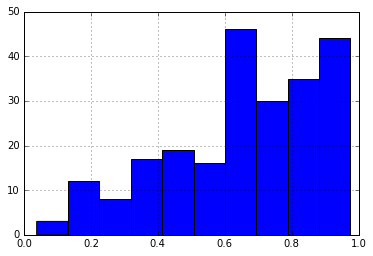

In [100]:
beatles_tracks['valence'].hist()

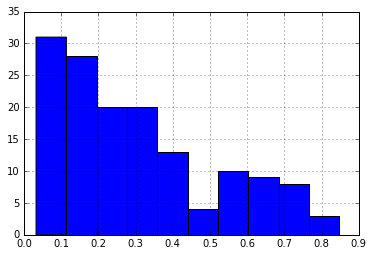

In [102]:
radiohead_tracks['valence'].hist()

## Lyrics search<a name="lyricssearch"></a>
Now to find the lyrics for each track. 

We start by searching for the Genius ID for the artists.

Note that Genius doesn't like Python-generated requests to its API, so we set the header to pretend to be a command-line `curl` request.

* [Top](#top)

In [58]:
def genius_artist_search(artist_name, per_page=20):
    query = urllib.parse.urlencode({'q': artist_name,
                                    'per_page': str(per_page)
                                   })
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request('https://api.genius.com/search?{}'.format(query), 
                                     headers=headers,
                                     method='GET')
    with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            return response

In [59]:
response = genius_artist_search('the beatles')
beatles_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
beatles_genius_id

586

In [103]:
response = genius_artist_search('radiohead')
radiohead_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
radiohead_genius_id

604

We can now get the song information for each track for each artist. Note that Genius keeps lots of things to do with artists, including sleeve notes and the like. We're just after the lyrics.

In [60]:
def genius_song_search(artist_id):
    songs = pd.DataFrame()
    page = 1
    while page:
        query = urllib.parse.urlencode({'page': page, 'per_page': 20})
        headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('https://api.genius.com/artists/{id}/songs?{query}'.format(id=artist_id,
                                                                                               query=query), 
                                     headers=headers,
                                     method='GET')
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            page = response['response']['next_page']
            for song in response['response']['songs']:
                if song['path'].endswith('lyrics'):
                    song['_id'] = song['id']
                    genius_tracks.replace_one({'_id': song['id']}, song, upsert=True)

In [61]:
genius_song_search(beatles_genius_id)
genius_tracks.find().count()

402

In [104]:
genius_song_search(radiohead_genius_id)
genius_tracks.find().count()

611

In [105]:
genius_tracks.find_one()

{'_id': 123816,
 'annotation_count': 5,
 'api_path': '/songs/123816',
 'ctitle': 'act naturally',
 'full_title': 'Act Naturally by\xa0The\xa0Beatles',
 'header_image_thumbnail_url': 'https://images.genius.com/adbf27acc77a06acfa4a506086952f31.300x300x1.jpg',
 'header_image_url': 'https://images.genius.com/adbf27acc77a06acfa4a506086952f31.600x600x1.jpg',
 'id': 123816,
 'lyrics': "they're gonna put me in the movies they're gonna make a big star out of me we'll make a film about a man that's sad and lonely and all i gotta do is act naturally well, i'll bet you i'm gonna be a big star might win an oscar you can never tell the movies gonna make me a big star cos i can play the part so well well i hope you'll come and see me in the movies then i know that you will plainly see the biggest fool that ever hit the big time and all i gotta do is act naturally we'll make the scene about a man that's sad and lonely and begging down upon his bended knee i'll play the part and i won't need rehearsing

In [106]:
gsongs = pd.DataFrame(list(genius_tracks.find()))
gsongs.T

,0,1,2,3,4,5,6,7,8,9,...,601,602,603,604,605,606,607,608,609,610
_id,123816,210315,210712,1497768,106576,210540,123533,1274297,210284,524428,...,63102,1039606,2469509,2904512,196343,65924,2913460,115809,114477,642622
annotation_count,5,1,2,1,12,0,5,1,1,1,...,5,1,8,0,9,8,0,7,4,1
api_path,/songs/123816,/songs/210315,/songs/210712,/songs/1497768,/songs/106576,/songs/210540,/songs/123533,/songs/1274297,/songs/210284,/songs/524428,...,/songs/63102,/songs/1039606,/songs/2469509,/songs/2904512,/songs/196343,/songs/65924,/songs/2913460,/songs/115809,/songs/114477,/songs/642622
ctitle,act naturally,a little rhyme,all things must pass,all together on the wireless machine,and your bird can sing,aint she sweet,and i love her,bad to me,beatle greetings,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
full_title,Act Naturally by The Beatles,A Little Rhyme by The Beatles (Ft. John & Rodn...,All Things Must Pass by The Beatles,All Together on the Wireless Machine by The Be...,And Your Bird Can Sing by The Beatles,Ain't She Sweet by The Beatles,And I Love Her by The Beatles,Bad to Me by The Beatles,Beatle Greetings by The Beatles (Ft. George Ha...,Everyone Needs Someone To Hate by On A Friday ...,...,The National Anthem by Radiohead,These Are My Twisted Words by Radiohead,Tinker Tailor Soldier Sailor Rich Man Poor Man...,To Be A Brilliant Light by On A Friday (Ft. Ra...,True Love Waits by Radiohead,Weird Fishes / Arpeggi by Radiohead,What Is It That You Say by On A Friday (Ft. Ra...,Where I End and You Begin by Radiohead,You and Whose Army? by Radiohead,You Never Wash Up After Yourself by Radiohead
header_image_thumbnail_url,https://images.genius.com/adbf27acc77a06acfa4a...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/77f6f3871295b6069761...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/59b22781e23136c9c464...,https://s3.amazonaws.com/rapgenius/view.jpg,https://images.genius.com/68c11c7f5b6b66194d77...,https://images.genius.com/6f304f07098a410106d9...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/486acf44f6ac31cc8352...,...,https://images.genius.com/672520006c5c85e87a29...,https://images.genius.com/4b253f662678407c1a66...,https://images.genius.com/c9cf30826b50b5096664...,https://images.genius.com/0d2b320176188d7579f9...,https://images.genius.com/c9cf30826b50b5096664...,https://images.genius.com/525c7ac8ba19f54cb8a5...,https://images.genius.com/76967c29fe8fa254f540...,https://images.genius.com/5ccb8a89b0f674962982...,https://s3.amazonaws.com/rapgenius/1359924238_...,https://images.rapgenius.com/0d14d86aec456da16...
header_image_url,https://images.genius.com/adbf27acc77a06acfa4a...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/77f6f3871295b6069761...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/59b22781e23136c9c464...,https://s3.amazonaws.com/rapgenius/view.jpg,https://images.genius.com/68c11c7f5b6b66194d77...,https://images.genius.com/6f304f07098a410106d9...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/486acf44f6ac31cc8352...,...,https://images.genius.com/672520006c5c85e87a29...,https://images.genius.com/4b253f662678407c1a66...,https://images.genius.com/c9cf30826b50b5096664...,https://images.genius.com/0d2b320176188d7579f9...,https://images.genius.com/c9cf30826b50b5096664...,https://images.genius.com/525c7ac8ba19f54cb8a5...,https://images.genius.com/76967c29fe8fa254f540...,https://images.genius.com/5ccb8a89b0f674962982...,https://s3.amazonaws.com/rapgenius/1359924238_...,https://images.rapgenius.com/0d14d86aec456da16...
id,123816,210315,210712,1497768,106576,210540,123533,1274297,210284,524428,...,63102,1039606,2469509,2904512,196343,65924,2913460,115809,114477,642622
lyrics,they're gonna put me in the movies they're gon...,"now, for the final number, john's got a card i...",sunrise doesn't last all morning a cloudburst ...,when i was sitting on my piano one day a m

Now we can get the lyrics for each song. We tidy it up as we go, to strip out formatting and the like.

Note the use of [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip out the HTML from the lyrics.

In [116]:
def genius_lyrics(song_url):
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request(song_url, headers=headers, method='GET')
    html_doc = urllib.request.urlopen(request)
    soup = BeautifulSoup(html_doc, 'html.parser')
    lyrics = soup.find('lyrics').get_text()
    l2 = re.sub('\[[^\]]*\]', '', lyrics)
    l3 = re.sub('\[|\]', '', l2)
    l4 = re.sub('(\s)+', ' ', l3)
    return l4.strip().lower(), lyrics

In [153]:
assl = genius_lyrics('https://genius.com/The-beatles-aint-she-sweet-lyrics')
assl

("oh ain't she sweet well see her walking down that street yes i ask you very confidentially ain't she sweet? oh ain't she nice well look her over once or twice yes i ask you very confidentially ain't she nice? just cast an eye in her direction oh me oh my ain't that perfection? oh i repeat well don't you think that's kind of neat? yes i ask you very confidentially ain't she sweet? oh ain't she sweet well see her walking down that street well i ask you very confidentially ain't she sweet? well i ask you very confidentially ain't she sweet?",
 "\n\n[Chorus 1]]\nOh ain't she sweet\nWell see her walking down that street\nYes I ask you very confidentially\nAin't she sweet?\n\n[Chorus 2]\nOh ain't she nice\nWell look her over once or twice\nYes I ask you very confidentially\nAin't she nice?\n\n[Chorus 3]\nJust cast an eye\nIn her direction\nOh me oh my\nAin't that perfection?\n\n[Chorus 4]\nOh I repeat\nWell don't you think that's kind of neat?\nYes I ask you very confidentially\nAin't she 

In [259]:
for gsong in genius_tracks.find({}, ['url']):
    lyrics, original_lyrics = genius_lyrics(gsong['url'])
    genius_tracks.update_one({'_id': gsong['_id']}, 
                             {'$set': {'lyrics': lyrics, 'original_lyrics': original_lyrics}})
genius_tracks.find_one({}, ['title', 'lyrics', 'original_lyrics'])

{'_id': 210315,
 'lyrics': 'now, for the final number, john\'s got a card in his hand with a little rhyme on it. what is it? it\'s from the form up a third at hemel hempstead oh! it says, "dear george, john, ringo, paul, here\'s hoping that you\'ll please us all a beauty song and swinging voice, we leave it up to you, the choice we think you\'re fab and really cool, so brighten up our lads at school" dig this, for here\'s paul, whistling "clarabella"',
 'original_lyrics': '\n\n[Speech]\n\n[Rodney Burke] Now, for the final number, John\'s got a card in his hand with a little rhyme on it. What is it?\n[John] It\'s from the form up a third at Hemel Hempstead\n[Rodney] Oh!\n[John] It says, "Dear George, John, Ringo, Paul, here\'s hoping that you\'ll please us all\nA beauty song and swinging voice, we leave it up to you, the choice\nWe think you\'re fab and really cool, so brighten up our lads at school"\nDig this, for here\'s Paul, whistling "Clarabella"\n\n',
 'title': 'A Little Rhyme'}

## Matching datasets<a name="matchingdatasets"></a>
Now it's time to match up the datasets. First, we simplify the titles of the tracks, to sidestep differences in punctuation, capitalisation, and the like.

* [Top](#top)

In [129]:
def canonical_name(text):
    t1 = re.sub(' - .*', '', text) # Strip the " - Remastered 2015" suffix
    t2 = re.sub('[^\w\s]', '', t1) # strip all characters except letters, numbers, and whitespace
    t3 = re.sub('\s+', ' ', t2) # collapse whitespace
    return t3.lower() # convert to lowercase and return

In [130]:
canonical_name("A Hard Day's Night - Live / Remastered")

'a hard days night'

Add the simplified title to each track in the Spotify and Genius collections.

In [131]:
for t in tracks.find():
    tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['name'])}})
for t in genius_tracks.find():
    genius_tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['title'])}})

Now to see what the differences are. Find the tracks that are in both collections, and tracks that are in only one.

In [141]:
in_both = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if tracks.find({'ctitle': g['ctitle']}).count())
genius_only = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if not tracks.find({'ctitle': g['ctitle']}).count())
spotify_only = set(s['ctitle'] for s in tracks.find({}, ['ctitle']) if not genius_tracks.find({'ctitle': s['ctitle']}).count())
len(in_both), len(genius_only), len(spotify_only)

(305, 294, 42)

In [134]:
spotify_only

{'2 2 5 live at earls court',
 'a punch up at a wedding',
 'bloom blawan rmx',
 'bloom harmonic 313 rmx',
 'bloom jamie xx rework',
 'bloom mark pritchard rmx',
 'bloom objekt rmx',
 'bullet proof i wish i was',
 'codex illum sphere',
 'dollars cents',
 'dollars cents live',
 'everything in its right place live in france',
 'feral lone rmx',
 'fog again live',
 'give up the ghost brokenchord rmx',
 'give up the ghost thriller houseghost remix',
 'good evening mrs magpie modeselektor rmx',
 'i might be wrong live',
 'i will los angeles version',
 'idioteque live in oxford',
 'kansas city heyheyheyhey',
 'like spinning plates live',
 'little by little caribou rmx',
 'little by little shed',
 'lotus flower jacques greene rmx',
 'lotus flower sbtrkt rmx',
 'march of the meanies',
 'morning bell live in oxford',
 'morning mr magpie nathan fake rmx',
 'morning mr magpie pearson sound scavenger rmx',
 'packt like sardines in a crushed tin box',
 'pepperland',
 'pepperland laid waste',
 'remyx

In [135]:
genius_only

{'1822',
 'a little rhyme',
 'a moon shaped pool tracklist album cover',
 'a picture of you',
 'a punchup at a wedding',
 'a reminder',
 'a shot of rhythm and blues',
 'across the universe wildlife version',
 'aint she sweet',
 'all things must pass',
 'all together on the wireless machine',
 'another beatles christmas record',
 'bad boy',
 'bad to me',
 'banana co',
 'beatle greetings',
 'beatles movie medley',
 'beautiful dreamer',
 'bebopalula',
 'because i know you love me so',
 'being for the benefit of mr kite take 7',
 'being for the benefit of mr kite takes 1 2',
 'being for the benefit of mr kitei want you shes so heavyhelter skelter',
 'besame mucho',
 'big boots',
 'big ideas',
 'bishops robes',
 'bitches talkin',
 'blackbirdyesterday',
 'blue moon of kentucky',
 'blue suede shoes',
 'bullet proofi wish i was',
 'burning bush',
 'can you take me back',
 'carol',
 'ceremony',
 'child of nature',
 'christmas time is here again',
 'cinnamon girl',
 'clarabella',
 'climbing up a

Manually fix a couple of errors.

In [453]:
genius_tracks.update_many({'ctitle': 'revolution i'}, 
                          {'$set': {'ctitle': 'revolution 1'}})
genius_tracks.update_many({'ctitle': 'when im sixtyfour'}, 
                          {'$set': {'ctitle': 'when im sixty four'}})
genius_tracks.update_many({'ctitle': 'packt like sardines in a crushd tin box'}, 
                          {'$set': {'ctitle': 'packt like sardines in a crushed tin box'}})
genius_tracks.update_many({'ctitle': 'a punchup at a wedding'}, 
                          {'$set': {'ctitle': 'a punch up at a wedding'}})
genius_tracks.update_many({'ctitle': 'dollars cents'}, 
                          {'$set': {'ctitle': 'dollars and cents'}})
genius_tracks.update_many({'ctitle': 'bullet proofi wish i was'}, 
                          {'$set': {'ctitle': 'bullet proof i wish i was'}})

In [454]:
in_both = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if tracks.find({'ctitle': g['ctitle']}).count())
genius_only = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if not tracks.find({'ctitle': g['ctitle']}).count())
spotify_only = set(s['ctitle'] for s in tracks.find({}, ['ctitle']) if not genius_tracks.find({'ctitle': s['ctitle']}).count())
len(in_both), len(genius_only), len(spotify_only)

(306, 293, 41)

### Copy the lyrics over<a name="copylyrics"></a>
Now can can connect the tracks, let's copy across the lyrics from the Genius collection into the Spotify collection. We'll calculate the lyrical density at the same time.

* [Top](#top)

In [455]:
for t in tracks.find({}, ['ctitle', 'duration_ms']):
    gts = genius_tracks.find({'ctitle': t['ctitle'], 'lyrics': {'$exists': True}}, ['lyrics', 'original_lyrics'])
    for gt in gts:
        tracks.update_one({'_id': t['_id']}, 
                          {'$set': {'lyrics': gt['lyrics'], 
                                    'original_lyrics': gt['original_lyrics'],
                                    'lyrical_density': 1000 * len(gt['lyrics'].split()) / t['duration_ms']}})

## Sentiment analysis<a name="sentimentanalysis"></a>
I couldn't find an easily-installable equivalent to the NRC corpus, so I'm using a sentiment analysis API endpoint from [Text Processing](http://text-processing.com/docs/sentiment.html).

* [Top](#top)

In [456]:
for t in tracks.find({'lyrics': {'$exists': True}}, ['lyrics']):
    text = t['lyrics']
    if text:
        query = urllib.parse.urlencode({'text': text}).encode('ascii')
        headers = {'Accept': 'application/json',
                   'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('http://text-processing.com/api/sentiment/', 
                                 headers=headers, data=query)
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            tracks.update_one({'_id': t['_id']}, {'$set': {'sentiment': response}})

In [173]:
tracks.find_one({'sentiment': {'$exists': True}}).keys()

dict_keys(['track_href', 'album', 'mode', 'tempo', 'loudness', 'id', 'valence', 'external_ids', 'artists', '_id', 'ctitle', 'sentiment', 'popularity', 'uri', 'energy', 'key', 'available_markets', 'href', 'original_lyrics', 'liveness', 'artist_name', 'external_urls', 'speechiness', 'track_number', 'name', 'analysis_url', 'lyrics', 'duration_ms', 'acousticness', 'preview_url', 'type', 'explicit', 'disc_number', 'danceability', 'time_signature', 'artist_id', 'instrumentalness'])

In [214]:
tracks.find_one({'sentiment': {'$exists': True}})

{'_id': '2ucFulEWapRAmTn7l6f5Q7',
 'acousticness': 0.425,
 'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
    'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
    'id': '3WrFJ7ztbogyGnTHbHJFl2',
    'name': 'The Beatles',
    'type': 'artist',
    'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
  'available_markets': ['AD',
   'AR',
   'AT',
   'AU',
   'BE',
   'BG',
   'BO',
   'BR',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'EC',
   'EE',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HU',
   'ID',
   'IE',
   'IS',
   'IT',
   'JP',
   'LI',
   'LT',
   'LU',
   'LV',
   'MC',
   'MT',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'PA',
   'PE',
   'PH',
   'PL',
   'PT',
   'PY',
   'SE',
   'SG',
   'SK',
   'SV',
   'TR',
   'TW',
   'UY'],
  'external_urls': {'spotify': 'https://open.spotify.com/a

# Analysis<a name="analysis"></a>
Finally, we can get to the analysis of the data!

First, what are the lowest-valence songs, and what's the distribution of valences?

* [Top](#top)

In [197]:
pd.DataFrame(list(tracks.find({}, 
                              ['artist_name', 'name', 'valence'], 
                              sort=[('valence', pymongo.ASCENDING)], limit=20)))

,_id,artist_name,name,valence
0,1AVrv7FD10FoKW38oBiKRg,Radiohead,Bloom (Blawan Rmx),0.0325
1,4rkGGQEqxHIXVJ4oXjOHgF,George Martin,Sea Of Holes - Remastered 2009,0.0352
2,01ZpFhrMMqKPVCwyqXneVp,Radiohead,True Love Waits,0.0378
3,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,We Suck Young Blood,0.0378
4,0ttMfoND7IQqFSMVOPkELC,The Beatles,Blue Jay Way - Remastered 2009,0.0380
5,66Pyms4pYaHEcPHZ7DdMbE,Radiohead,TKOL (Altrice Rmx),0.0383
6,3gKuywOm38axM8sJGq6Laq,Radiohead,MK 1,0.0391
7,75YUnz58ajMo2VIIuUFvOV,Radiohead,The Tourist,0.0400
8,0tKuiKb2mazZYdA6fPP7kI,Radiohead,Good Evening Mrs Magpie (Modeselektor RMX),0.0413
9,2PbwmAMaxIBIWis8XLViat,George Martin,Sea Of Monsters - Remastered 2009,0.0422


In [458]:
beatles_df = pd.DataFrame(list(tracks.find({'artist_id': beatles_id}, 
                              ['artist_name', 'name', 'valence'])))
beatles_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
83,0ttMfoND7IQqFSMVOPkELC,The Beatles,Blue Jay Way - Remastered 2009,0.0380
180,0agoaPIy92gPZ6zRhqXarE,The Beatles,Tomorrow Never Knows - Remastered 2009,0.0556
228,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,Revolution 9 - Remastered 2009,0.0963
207,27YZJHyTTDIurMqDu1v2ef,The Beatles,"Long, Long, Long - Remastered 2009",0.1350
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,Wild Honey Pie - Remastered 2009,0.1530
196,4cLoL5KPfE1hAwfsO84FX7,The Beatles,Because - Remastered 2009,0.1620
103,3ZFBeIyP41HhnALjxWy1pR,The Beatles,A Day In The Life - Remastered 2009,0.1620
36,7iABnSNZciNepqGtjMQxxd,The Beatles,Come Together - Remastered 2015,0.1780
48,0MKqeOVdZcUFGJvWpGCKbG,The Beatles,Come Together - Remastered 2009,0.1790
59,4gUUfLOH38XYU5Q3b2K4Go,The Beatles,It's All Too Much - Remastered 2009,0.1920


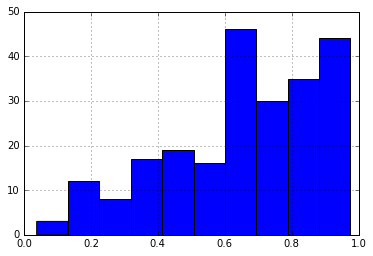

In [459]:
beatles_df['valence'].hist()

In [460]:
radiohead_df = pd.DataFrame(list(tracks.find({'artist_id': radiohead_id}, 
                              ['artist_name', 'name', 'valence'])))
radiohead_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
14,1AVrv7FD10FoKW38oBiKRg,Radiohead,Bloom (Blawan Rmx),0.0325
131,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,We Suck Young Blood,0.0378
123,01ZpFhrMMqKPVCwyqXneVp,Radiohead,True Love Waits,0.0378
13,66Pyms4pYaHEcPHZ7DdMbE,Radiohead,TKOL (Altrice Rmx),0.0383
20,3gKuywOm38axM8sJGq6Laq,Radiohead,MK 1,0.0391
117,75YUnz58ajMo2VIIuUFvOV,Radiohead,The Tourist,0.0400
15,0tKuiKb2mazZYdA6fPP7kI,Radiohead,Good Evening Mrs Magpie (Modeselektor RMX),0.0413
140,0COiZ7ncho2yi4HotbzgPv,Radiohead,Motion Picture Soundtrack,0.0425
21,2uYSbsxAMmK1awUl06T7ix,Radiohead,MK 2,0.0437
143,4gq2bc2770XvbJdEtfUbmw,Radiohead,Go Slowly,0.0453


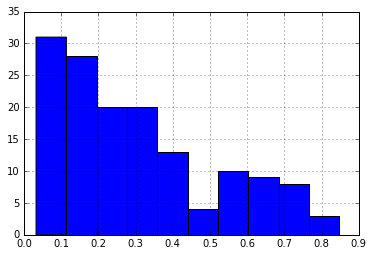

In [461]:
radiohead_df['valence'].hist()

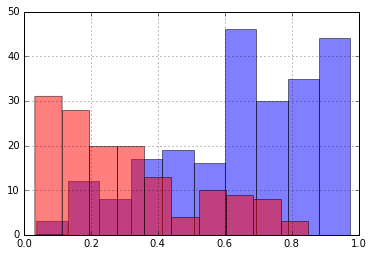

In [462]:
beatles_df['valence'].hist(alpha=0.5, color='blue')
radiohead_df['valence'].hist(alpha=0.5, color='red')

### Sentiment<a name="sentiment"></a>
We can now look at the sentiment scores for the lyrics.

* [Top](#top)

In [463]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': beatles_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
beatles_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
beatles_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
67,3VgxeWOGdUYvtX1j8C9VyV,The Beatles,I'm So Tired - Remastered 2009,0.892489,0.146302,0.107511,0.6300
50,6gLmFcRwyQCQT23Df2Re9G,The Beatles,I Want You (She's So Heavy) - Remastered 2009,0.882642,0.091819,0.117358,0.4160
226,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,Revolution 9 - Remastered 2009,0.873285,0.172322,0.126715,0.0963
213,3EbGioQyKyf4dycuiPOg3k,The Beatles,Everybody's Trying To Be My Baby - Remastered ...,0.866985,0.914332,0.133015,0.9370
191,79QDgDoBbS7pCrOjIH7ByA,The Beatles,Everybody’s Trying To Be My Baby - Live / Bonu...,0.866985,0.914332,0.133015,0.6390
42,4311wT21Et0q3vepFwXjTu,The Beatles,One After 909 - Remastered 2009,0.865737,0.158470,0.134263,0.9040
113,3QbhVaulXxTyuAxHY3Pa5N,The Beatles,You Won't See Me - Remastered 2009,0.864585,0.247226,0.135415,0.4620
149,3Aqo28W4LLAolYpN3duVJl,The Beatles,I'll Cry Instead - Remastered 2009,0.863772,0.160516,0.136228,0.9610
70,3OSi8ehmSWLTD5KatlzX8r,The Beatles,Don't Pass Me By - Remastered 2009,0.857831,0.120676,0.142169,0.9480
104,3wAOX1N5M0ta3QNsokmhJV,The Beatles,I'm Only Sleeping - Remastered 2009,0.857651,0.269800,0.142349,0.7000


In [464]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': radiohead_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
radiohead_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
radiohead_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
23,11qDTSr3Dj4TkPnBcIOqEJ,Radiohead,Vegetable,0.883291,0.170371,0.116709,0.399
60,38WL6GlG9NHFiQS6JxV84r,Radiohead,Myxomatosis,0.864921,0.261355,0.135079,0.560
19,2zYmvi3w2T8a9Ckrv21bvW,Radiohead,Stop Whispering,0.855982,0.188600,0.144018,0.279
87,1w8QCSDH4QobcQeT4uMKLm,Radiohead,4 Minute Warning,0.854820,0.516574,0.145180,0.219
9,3aDUSpF3LexOr1lFKvPV2h,Radiohead,The Bends,0.854244,0.533823,0.145756,0.315
25,48IEDejXX5LH8TAC3VIGpc,Radiohead,I Can't,0.849730,0.265375,0.150270,0.269
5,3SVAN3BRByDmHOhKyIDxfC,Radiohead,Karma Police,0.846129,0.100438,0.153871,0.311
14,4dPKQxaraW6CG1rTBzV6DW,Radiohead,My Iron Lung,0.845080,0.190863,0.154920,0.643
43,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,Faust Arp,0.838532,0.167778,0.161468,0.224
57,77SPrxY5gn6VPrKPGrfLnM,Radiohead,"There, There",0.835541,0.135951,0.164459,0.726


Plot the valence/negativity scatter plot, using blue for The Beatles and red for Radiohead.

If valence and negativity are correlated, I'd expect to see a trend from high negativity/low valence to low negativity/high valence.

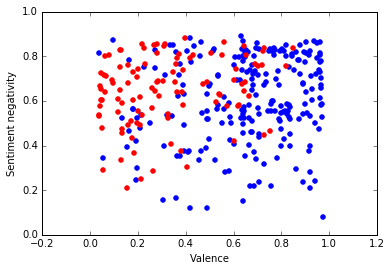

In [465]:
plt.scatter(beatles_df['valence'], beatles_df['neg'], color='blue')
plt.scatter(radiohead_df['valence'], radiohead_df['neg'], color='red')
plt.xlabel('Valence')
plt.ylabel('Sentiment negativity')
plt.show()

Positivity and negativity are connected.

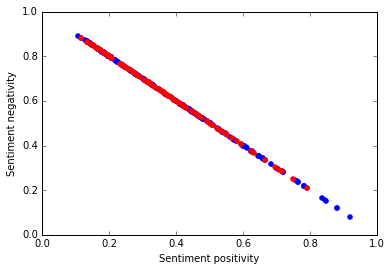

In [466]:
plt.scatter(beatles_df['pos'], beatles_df['neg'], color='blue')
plt.scatter(radiohead_df['pos'], radiohead_df['neg'], color='red')
plt.xlabel('Sentiment positivity')
plt.ylabel('Sentiment negativity')
plt.show()

Neutrality, I think, is to do with the confidence in the classification.

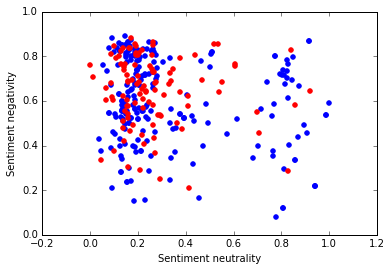

In [467]:
plt.scatter(beatles_df['neutral'], beatles_df['neg'], color='blue')
plt.scatter(radiohead_df['neutral'], radiohead_df['neg'], color='red')
plt.xlabel('Sentiment neutrality')
plt.ylabel('Sentiment negativity')
plt.show()

This plot shows that most songs have a low neutrality, so express a clear sentiment in the lyrics. Let's plot the distribution of "neutral" scores to highlight this.

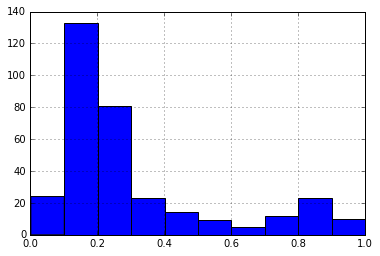

In [468]:
beatles_df.append(radiohead_df)['neutral'].hist()

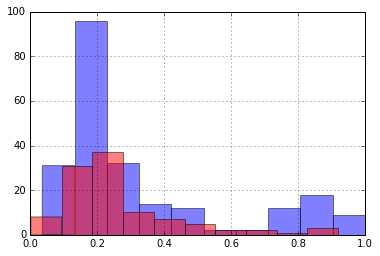

In [469]:
beatles_df['neutral'].hist(alpha=0.5, color='blue')
radiohead_df['neutral'].hist(alpha=0.5, color='red')

### Gloom index<a name="gloomindex"></a>
Let's recreate the "gloom index" idea from the original post and see what it tells us. Bear in mind that I'm using the sentiment negativity score, not the fraction of "sad" words.

* [Top](#top)

In [470]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
247,66cuLvkHsW7dNkfNk6gQP9,Radiohead,1.505262,1.991725,A Wolf At the Door,0.793363,0.3630
3,0GRplBEB2FWCKutwMmS6nY,The Beatles,1.475037,1.853118,Ticket To Ride - Live / Remastered,0.825439,0.4050
229,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,1.398920,1.411166,Faust Arp,0.838532,0.2240
68,3VgxeWOGdUYvtX1j8C9VyV,The Beatles,1.393697,1.708599,I'm So Tired - Remastered 2009,0.892489,0.6300
328,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,1.270327,0.874479,Revolution 9 - Remastered 2009,0.873285,0.0963
278,5H9q6ctIlamkqukdTrNt3k,The Beatles,1.261539,2.616693,Her Majesty - Remastered 2009,0.556608,0.4900
183,3aDUSpF3LexOr1lFKvPV2h,Radiohead,1.239768,1.100731,The Bends,0.854244,0.3150
17,0mNQUZEATk2uItMUtiLWK5,The Beatles,1.213645,1.615224,A Hard Day's Night - Remastered 2015,0.833309,0.7520
82,0ttMfoND7IQqFSMVOPkELC,The Beatles,1.212148,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380
126,5ou2BiQ9FxIYkxsYvYHpAT,The Beatles,1.210378,1.648037,Help! - Remastered 2009,0.823915,0.7610


In [471]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': radiohead_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
61,66cuLvkHsW7dNkfNk6gQP9,Radiohead,1.505262,1.991725,A Wolf At the Door,0.793363,0.3630
43,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,1.398920,1.411166,Faust Arp,0.838532,0.2240
9,3aDUSpF3LexOr1lFKvPV2h,Radiohead,1.239768,1.100731,The Bends,0.854244,0.3150
34,0eZN5WsQfmNFICHuw59Zfz,Radiohead,1.150902,0.705463,Glass Eyes,0.800195,0.0629
20,3ovbSnT5NNhl1gzMcw1NRZ,Radiohead,1.142115,1.151468,Thinking About You,0.791660,0.4190
11,045sp2JToyTaaKyXkGejPy,Radiohead,1.090813,0.581341,Fake Plastic Trees,0.827542,0.1270
24,4D6ZExVvYLZxhcAvifX5px,Radiohead,1.074047,0.749795,Prove Yourself,0.815006,0.2780
13,4SE81CrzH0qPA8KHqM9Syz,Radiohead,1.064914,0.856048,Just,0.809154,0.3720
4,4aOAzvRdOsZSwZIgwcdeL0,Radiohead,1.063868,0.524102,Let Down,0.825887,0.1310
23,11qDTSr3Dj4TkPnBcIOqEJ,Radiohead,1.056187,0.711071,Vegetable,0.883291,0.3990


These, in theory, are the most depressing Radiohead songs. For information, the [fitteR happieR songs](http://rcharlie.com/2017-02-16-fitteR-happieR/) were:

  | gloom_index|               track_name
--|------------|--------------------------|
1 |        1.00 |           True Love Waits
2 |        6.46 |        Give Up The Ghost
3 |        9.35 | Motion Picture Soundtrack
4 |       13.70 |                 Let Down
5 |       14.15 |             Pyramid Song
6 |       14.57 |  Exit Music (For a Film)
7 |       15.29 |          Dollars & Cents
8 |       15.69 |              High And Dry
9 |       15.80 | Tinker Tailor Soldier ...
10|       16.03 |                Videotape

...which has only one song in common, "Let Down". I'm not convinced by this analysis.

What does the same analysis say for The Beatles?

In [472]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': beatles_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
3,0GRplBEB2FWCKutwMmS6nY,The Beatles,1.475037,1.853118,Ticket To Ride - Live / Remastered,0.825439,0.4050
67,3VgxeWOGdUYvtX1j8C9VyV,The Beatles,1.393697,1.708599,I'm So Tired - Remastered 2009,0.892489,0.6300
226,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,1.270327,0.874479,Revolution 9 - Remastered 2009,0.873285,0.0963
201,5H9q6ctIlamkqukdTrNt3k,The Beatles,1.261539,2.616693,Her Majesty - Remastered 2009,0.556608,0.4900
17,0mNQUZEATk2uItMUtiLWK5,The Beatles,1.213645,1.615224,A Hard Day's Night - Remastered 2015,0.833309,0.7520
81,0ttMfoND7IQqFSMVOPkELC,The Beatles,1.212148,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380
125,5ou2BiQ9FxIYkxsYvYHpAT,The Beatles,1.210378,1.648037,Help! - Remastered 2009,0.823915,0.7610
9,1alcPfZWUHh01l4Fnoo5Jt,The Beatles,1.203416,1.332561,Help! - Live / Remastered,0.823915,0.5150
164,2Iccm3cKBQHWt5yk0yX9nh,The Beatles,1.200158,1.530785,Please Please Me - Remastered 2009,0.833068,0.7080
21,1dfuJYDSIc41cw5RPsaCF1,The Beatles,1.187438,1.651824,Help! - Remastered 2015,0.823915,0.8100


### Revised gloom index<a name="revisedgloomindex"></a>
I don't like the calculation for gloom index. If the point of "lyrical density" is to scale the gloom index between valence and sentiment, depending on how many words are in the song.

* [Top](#top)

In [473]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density'}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))

# Use pandas to scale the lyrical density values to the range 0 -1
results['scaled_ld'] = (results['lyrical_density'] - results['lyrical_density'].min()) / \
    (results['lyrical_density'].max() - results['lyrical_density'].min())

# Define a Python function to calculate the revised gloom index
def gloom(row):
    w_valence = (1 - row['valence']) * (1 - row['scaled_ld'])
    w_neg = row['neg'] * row['scaled_ld']
    return (w_valence + w_neg) / 2

# Apply this function to create a new column
results['gloom'] = results.apply(gloom, axis=1)

# Push the results back into the database
for row in results.itertuples():
    tracks.update_one({'_id': row[1]}, {'$set': {'gloom': row.gloom}})

results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
331,4gq2bc2770XvbJdEtfUbmw,Radiohead,0.201546,Go Slowly,0.723774,0.0453,0.039619,0.472775
279,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0400,0.056658,0.471724
309,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0378,0.045911,0.471229
315,5olWalQH1oVza5D6xJg4oX,Radiohead,0.216752,Sail To The Moon,0.605798,0.0458,0.045189,0.469228
317,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.067027,0.466795
330,4sLGaMl33I6mcsk7u4xHAU,Radiohead,0.146307,Codex,0.637942,0.0629,0.019385,0.465650
82,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380,0.258755,0.461657
326,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0425,0.093690,0.460916
232,3uxhyRdWVXp7GQvERQl6fA,Radiohead,0.382643,Videotape,0.652962,0.0468,0.105957,0.460694
265,7wB2VenWR6rchtLwawreIg,Radiohead,0.359311,Bullet Proof ... I Wish I Was,0.804636,0.0781,0.097410,0.455239


In [474]:
results[results['artist_name'] == 'Radiohead'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
331,4gq2bc2770XvbJdEtfUbmw,Radiohead,0.201546,Go Slowly,0.723774,0.0453,0.039619,0.472775
279,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0400,0.056658,0.471724
309,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0378,0.045911,0.471229
315,5olWalQH1oVza5D6xJg4oX,Radiohead,0.216752,Sail To The Moon,0.605798,0.0458,0.045189,0.469228
317,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.067027,0.466795
330,4sLGaMl33I6mcsk7u4xHAU,Radiohead,0.146307,Codex,0.637942,0.0629,0.019385,0.465650
326,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0425,0.093690,0.460916
232,3uxhyRdWVXp7GQvERQl6fA,Radiohead,0.382643,Videotape,0.652962,0.0468,0.105957,0.460694
265,7wB2VenWR6rchtLwawreIg,Radiohead,0.359311,Bullet Proof ... I Wish I Was,0.804636,0.0781,0.097410,0.455239
251,5AiNZnMDCWwujIENPj9PV9,Radiohead,0.489208,Everything In Its Right Place,0.716829,0.0585,0.144992,0.454462


This still isn't the same as the original list, though there are now two songs in common!


  | gloom_index |               track_name
--|-------------|--------------------------
1 |        1.00 |           True Love Waits
2 |        6.46 |        Give Up The Ghost
3 |        9.35 | Motion Picture Soundtrack
4 |       13.70 |                 Let Down
5 |       14.15 |             Pyramid Song
6 |       14.57 |  Exit Music (For a Film)
7 |       15.29 |          Dollars & Cents
8 |       15.69 |              High And Dry
9 |       15.80 | Tinker Tailor Soldier ...
10|       16.03 |                Videotape


In [475]:
results[results['artist_name'] == 'The Beatles'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
82,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380,0.258755,0.461657
328,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,0.874479,Revolution 9 - Remastered 2009,0.873285,0.0963,0.286121,0.447499
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,0.169898,Wild Honey Pie - Remastered 2009,0.391178,0.1530,0.028026,0.417113
102,3ZFBeIyP41HhnALjxWy1pR,The Beatles,0.628310,A Day In The Life - Remastered 2009,0.781296,0.1620,0.195947,0.413445
204,0agoaPIy92gPZ6zRhqXarE,The Beatles,0.634931,Tomorrow Never Knows - Remastered 2009,0.343599,0.0556,0.198372,0.412609
285,27YZJHyTTDIurMqDu1v2ef,The Beatles,0.429399,"Long, Long, Long - Remastered 2009",0.524122,0.1350,0.123084,0.411522
271,4cLoL5KPfE1hAwfsO84FX7,The Beatles,0.325955,Because - Remastered 2009,0.466254,0.1620,0.085191,0.403165
53,71Ij3VBYQWMrng61Ae4tBu,The Beatles,0.592658,You Never Give Me Your Money - Remastered 2009,0.753448,0.2260,0.182887,0.385121
272,3jPXnX4SskFgAcC4YBKOwN,The Beatles,0.273472,Sun King - Remastered 2009,0.300809,0.1970,0.065966,0.384936
34,7iABnSNZciNepqGtjMQxxd,The Beatles,0.800176,Come Together - Remastered 2015,0.562552,0.1780,0.258903,0.377414


I don't know the Radiohead corpus, but I know some Beatles songs. _Blue Jay Way_ is pretty sad, as is _A Day in the Life_. _Revolution 9_ and _Wild Honey Pie_ are just... odd, rather than sad. It's suspicious that some obviously sad Beatles songs are missing. What does this analysis think of unequivocally sad songs like _She's Leaving Home_, _Yesterday_, and _Eleanor Rigby_?

In [477]:
slh = tracks.find_one({'ctitle': 'shes leaving home'})['_id']
yd = tracks.find_one({'ctitle': 'yesterday'})['_id']
er = tracks.find_one({'ctitle': 'eleanor rigby'})['_id']
results[results['_id'].isin([slh, yd, er])].sort_values('gloom', ascending=False)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
136,1e0hllQ23AG0QGFgezgLOq,The Beatles,1.002650,Yesterday - Remastered 2009,0.852156,0.333,0.333071,0.364335
95,1Ipl1kvks5s6GKn6oqgzeY,The Beatles,1.064324,She's Leaving Home - Remastered 2009,0.764553,0.377,0.355663,0.336673
26,0TRkjwb4uY3CHb5zhr9bBd,The Beatles,1.628703,Eleanor Rigby - Remastered 2015,0.803232,0.845,0.562401,0.259783


### Glee index: anti-gloom<a name="gleeindex"></a>
Rather than looking at the saddest songs, how about using the same data to find the happiest songs?

* [Top](#top)

In [478]:
results.sort_values('gloom', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
63,3fuEJBCK3kWnJHFTODR4cb,The Beatles,1.608806,"Ob-La-Di, Ob-La-Da - Remastered 2009",0.080969,0.975,0.555112,0.028035
160,16aAwvjzWhM4Cgg5RYz2fA,The Beatles,0.884919,Money (That's What I Want) - Remastered 2009,0.208469,0.920,0.289945,0.058624
57,3TEbDhNDU4NDXq0h86nGZ7,The Beatles,1.008850,Hey Bulldog - Remastered 2009,0.239198,0.942,0.335342,0.059382
300,5VsIn7QQqcacePIb0vO0ow,The Beatles,0.465201,Not A Second Time - Remastered 2009,0.773805,0.961,0.136198,0.069540
203,4KIXWIzNcKzorNDgvMQwmD,The Beatles,0.631592,Birthday - Remastered 2009,0.373731,0.916,0.197149,0.070560
210,7cPPyMrSAQY7A686Cn9eUP,The Beatles,0.891649,All My Loving - Remastered 2009,0.235023,0.891,0.292411,0.072925
293,3EbGioQyKyf4dycuiPOg3k,The Beatles,0.438356,Everybody's Trying To Be My Baby - Remastered ...,0.866985,0.937,0.126365,0.082298
44,0cJ053ljI4BuP5P8tJnK5j,The Beatles,0.893485,For You Blue - Remastered 2009,0.471827,0.958,0.293083,0.083988
299,6xJSJpO6HJwHhu7UaIc8qR,The Beatles,0.585885,Hold Me Tight - Remastered 2009,0.804870,0.963,0.180406,0.087764
39,72Ob0wrObCXgvGYhFs8vip,The Beatles,0.938049,Across The Universe - Remastered 2009,0.295525,0.862,0.309408,0.093370


All the top ten most gleeful songs are from The Beatles!

What about the most gleeful Radiohead songs?

In [479]:
results[results['artist_name'] == 'Radiohead'].sort_values('gloom', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
49,0eECFDnWy0RdjMmJ8NOeAL,Radiohead,0.093389,Feral,0.465216,0.751,0.000000,0.124500
225,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,0.674272,15 Step,0.835488,0.848,0.212783,0.148717
243,77SPrxY5gn6VPrKPGrfLnM,Radiohead,0.438813,"There, There",0.835541,0.726,0.126532,0.172527
240,6CVdTDYoDbwYj4xn8u5Gha,Radiohead,0.452573,Backdrifts,0.821532,0.724,0.131573,0.173889
231,15ea10YpJIl3mJq75yzqsD,Radiohead,0.952216,Jigsaw Falling Into Place,0.757225,0.818,0.314597,0.181482
236,6P67UTTr5qN7XYSSlj0n6X,Radiohead,0.503609,Paperbag Writer,0.754680,0.704,0.150268,0.182462
327,3OsUjkcv1C1v5udFhgRSFg,Radiohead,0.329999,Airbag,0.642348,0.642,0.086673,0.191323
180,53aFGAl0Vebwp2bo8wtdWR,Radiohead,2.019892,Fitter Happier,0.446841,0.728,0.705697,0.197693
237,3STByesnbcQatiGHgwi1Tv,Radiohead,0.622541,I Am a Wicked Child,0.763706,0.688,0.193834,0.199778
308,3pcCifdPTc2BbqmWpEhtUd,Radiohead,0.439692,Burn the Witch,0.582602,0.625,0.126854,0.200668


### Contrasting songs<a name="valencenegcontrast"></a>
Going back to the scatter plot of negativity against valence, there are some songs with a high valence (i.e. sound happy) with a high negativity (i.e. sad words). This seems unusual. What songs are they?

* [Top](#top)

These are the songs I mean:

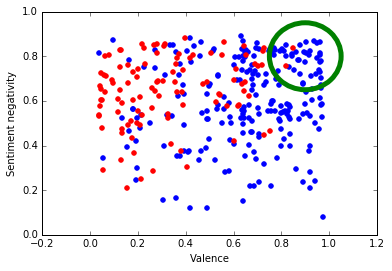

In [480]:
plt.scatter(beatles_df['valence'], beatles_df['neg'], color='blue')
plt.scatter(radiohead_df['valence'], radiohead_df['neg'], color='red')
plt.xlabel('Valence')
plt.ylabel('Sentiment negativity')

ax = plt.gca()
circ = plt.Circle((0.9, 0.8), radius=0.15, color='g', fill=False, linewidth=5)
ax.add_patch(circ)

plt.show()

In [481]:
results[(results['valence'] > 0.8) & (results['neg'] > 0.7)]

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
16,7pQAq14Z73YUFMtxCyt0bG,The Beatles,1.516618,Can't Buy Me Love - Remastered 2015,0.738387,0.957,0.521343,0.202768
21,1dfuJYDSIc41cw5RPsaCF1,The Beatles,1.651824,Help! - Remastered 2015,0.823915,0.810,0.570870,0.275942
26,0TRkjwb4uY3CHb5zhr9bBd,The Beatles,1.628703,Eleanor Rigby - Remastered 2015,0.803232,0.845,0.562401,0.259783
37,57n1teNb2tkcfiYagPmUWr,The Beatles,0.885556,Two Of Us - Remastered 2009,0.711080,0.923,0.290179,0.130498
42,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered 2009,0.865737,0.904,0.229005,0.136137
71,3OSi8ehmSWLTD5KatlzX8r,The Beatles,0.733338,Don't Pass Me By - Remastered 2009,0.857831,0.948,0.234420,0.120451
104,77f3aNeabAbOaSB32Sd5QE,The Beatles,1.620131,Eleanor Rigby - Remastered 2009,0.803232,0.821,0.559261,0.264054
132,67tvBtAhsfHBFpuqJ13ZUq,The Beatles,0.924368,Act Naturally - Remastered 2009,0.722619,0.946,0.304396,0.128762
133,1k9tpndMDRwLkNt67Dlg02,The Beatles,1.408837,You Like Me Too Much - Remastered 2009,0.773406,0.900,0.481862,0.212244
135,67VdmhC89bZ6yK2XRys0lA,The Beatles,1.087652,I've Just Seen A Face - Remastered 2009,0.805204,0.917,0.364208,0.173016


That's intersting. This list contains a lot of the Beatles' most well-known songs. Is there something in this?

Let's define "complexity" as the product of valence and negativity, and see which are the most complext songs.

In [484]:
results['complexity'] = results['valence'] * results['neg']
results.sort_values('complexity', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom,complexity
150,3Aqo28W4LLAolYpN3duVJl,The Beatles,1.349222,I'll Cry Instead - Remastered 2009,0.863772,0.961,0.460024,0.209207,0.830085
71,3OSi8ehmSWLTD5KatlzX8r,The Beatles,0.733338,Don't Pass Me By - Remastered 2009,0.857831,0.948,0.234420,0.120451,0.813223
293,3EbGioQyKyf4dycuiPOg3k,The Beatles,0.438356,Everybody's Trying To Be My Baby - Remastered ...,0.866985,0.937,0.126365,0.082298,0.812365
156,5IIBY9M2GxHcVja6DA6wsF,The Beatles,1.362221,Please Mister Postman - Remastered 2009,0.815201,0.962,0.464786,0.199616,0.784223
42,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered 2009,0.865737,0.904,0.229005,0.136137,0.782626
299,6xJSJpO6HJwHhu7UaIc8qR,The Beatles,0.585885,Hold Me Tight - Remastered 2009,0.804870,0.963,0.180406,0.087764,0.775090
155,0lLeGCsQlAbEjQBPQQxQ1b,The Beatles,0.998293,Don't Bother Me - Remastered 2009,0.824879,0.921,0.331476,0.163120,0.759713
201,4zExFATo8xg8qFfR4H1ZAn,The Beatles,1.364176,Why Don't We Do It In The Road? - Remastered 2009,0.793242,0.951,0.465502,0.197723,0.754373
159,3Ltllbv2lbpjP6NgPMNiFg,The Beatles,1.101133,Devil In Her Heart - Remastered 2009,0.779220,0.964,0.369147,0.155179,0.751168
297,55nE9EppLFdb0I1HBg2O2m,The Beatles,0.695489,Little Child - Remastered 2009,0.848886,0.878,0.220555,0.141159,0.745322


There's possibly something in it. The most "complex" song has a very upbeat pop tune and very sad lyrics. The others are similarly interesting.

What about the least "complex" songs?

In [485]:
results.sort_values('complexity', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom,complexity
222,6f6pEjgfTtuRROmJ4a7Gf3,Radiohead,0.393192,The Numbers,0.292008,0.0545,0.109821,0.436866,0.015914
204,0agoaPIy92gPZ6zRhqXarE,The Beatles,0.634931,Tomorrow Never Knows - Remastered 2009,0.343599,0.0556,0.198372,0.412609,0.019104
309,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0378,0.045911,0.471229,0.020117
317,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.067027,0.466795,0.020237
326,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0425,0.093690,0.460916,0.024514
224,3cual6JOG286qZJmCxKRAT,Radiohead,0.332577,Tinker Tailor Soldier Sailor Rich Man Poor Man...,0.477322,0.0517,0.087617,0.453517,0.024678
279,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0400,0.056658,0.471724,0.026715
315,5olWalQH1oVza5D6xJg4oX,Radiohead,0.216752,Sail To The Moon,0.605798,0.0458,0.045189,0.469228,0.027746
232,3uxhyRdWVXp7GQvERQl6fA,Radiohead,0.382643,Videotape,0.652962,0.0468,0.105957,0.460694,0.030559
82,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.812490,0.0380,0.258755,0.461657,0.030875


Interestingly, all of the "complex" songs are by The Beatles, while most of the least "complex" songs are by Radiohead. How true is that for all songs?

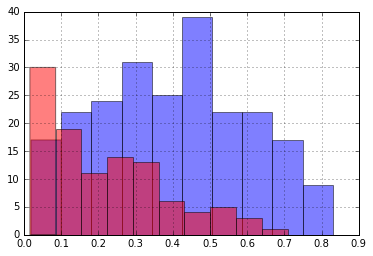

In [486]:
results[results['artist_name'] == 'The Beatles']['complexity'].hist(alpha=0.5, color='blue')
results[results['artist_name'] == 'Radiohead']['complexity'].hist(alpha=0.5, color='red')

In [487]:
# Push the results back into the database
for row in results.itertuples():
    tracks.update_one({'_id': row[1]}, {'$set': {'complexity': row.complexity}})

### Average gloom per album<a name="gloomperalbum"></a>
How close can we easily get to the final plot at the end of the fitteR happieR post?

First, we find average gloom per album.

* [Top](#top)

In [488]:
pipeline = [
    {'$match': {'gloom': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_gloom': {'$avg': '$gloom'}}}]
album_glooms = collections.defaultdict(int, {a['_id']: a['avg_gloom'] for a in tracks.aggregate(pipeline)})
album_glooms

defaultdict(int,
            {'03Qh833fEdVT30Pfs93ea6': 0.24623580565335346,
             '0PYyrqs9NXtxPhf0CZkq2L': 0.23500175198141865,
             '19K3IHYeVkUTjcBHGfbCOi': 0.22062175593822883,
             '19RUXBFyM4PpmrLRdtqWbp': 0.3431302979758603,
             '1DBkJIEoeHrTX4WCBQGcCi': 0.28205809775367074,
             '1PULmKbHeOqlkIwcDMNwD4': 0.2284613266716491,
             '1oW3v5Har9mvXnGk0x4fHm': 0.3137553965448286,
             '2Pqkn9Dq2DFtdfkKAeqgMd': 0.2884934384506727,
             '2pCqZLeavM2BMovJXsJEIV': 0.21860763995041954,
             '36lJLPoPPOKNFddTAcirnc': 0.3821905201779125,
             '3OdI6e43crvyAHhaqpxSyz': 0.21217853501580114,
             '3nkEsxmIX0zRNXGAexaHAn': 0.15002262857925622,
             '47bcKzmKgmMPHXNVOWpLiu': 0.17887638062333686,
             '500FEaUzn8lN9zWFyZG5C2': 0.3411762104912796,
             '5XfJmldgWzrc1AIdbBaVZn': 0.25065567867237876,
             '5ju5Ouzan3QwXqQt1Tihbh': 0.22362482844412274,
             '6400dnyeDyD2mIF

In [489]:
albums_df = pd.DataFrame(list(albums.find({}, ['release_date', 'name', 'artist_name'])))

def try_date(d):
    try:
        return datetime.strptime(d, "%Y-%m-%d")
    except ValueError:
        return datetime.strptime(d, "%Y")

albums_df['release_date'] = albums_df['release_date'].apply(lambda d: try_date(d))
albums_df['gloom'] = albums_df['_id'].apply(lambda i: album_glooms[i])
albums_df.sort_values('release_date', inplace=True)
albums_df

,_id,artist_name,name,release_date,gloom
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.178420
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.150023
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.215407
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.175109
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.220622
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03,0.212179
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05,0.235002
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01,0.228461
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27,0.268458
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22,0.246236


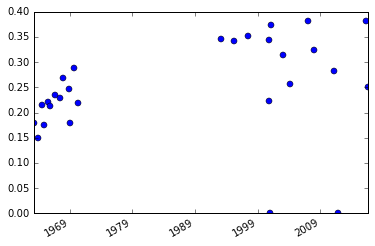

In [490]:
fig, ax = plt.subplots()
ax.plot_date(albums_df['release_date'], albums_df['gloom'])

fig.autofmt_xdate()
plt.show()

One thing that's noticable is the split in time between the groups, and the much shorter period the Beatles were active for.

In [491]:
beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
beatles_df

,_id,artist_name,name,release_date,gloom
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.178420
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.150023
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.215407
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.175109
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.220622
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03,0.212179
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05,0.235002
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01,0.228461
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27,0.268458
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22,0.246236


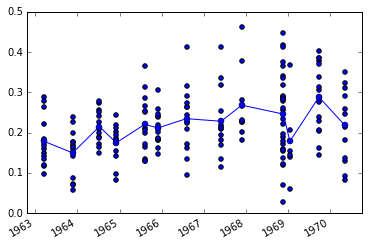

In [492]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['gloom'].values, linestyle='-')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

plt.show()

In [493]:
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]
radiohead_df

,_id,artist_name,name,release_date,gloom
27,6400dnyeDyD2mIFHfkwHXN,Radiohead,Pablo Honey,1993-02-22,0.345315
26,500FEaUzn8lN9zWFyZG5C2,Radiohead,The Bends,1995-03-28,0.341176
25,7dxKtc08dYeRVHt3p9CZJn,Radiohead,OK Computer,1997-05-28,0.352718
24,19RUXBFyM4PpmrLRdtqWbp,Radiohead,Kid A,2000-10-01,0.343130
23,6V9YnBmFjWmXCBaUVRCVXP,Radiohead,Amnesiac,2001-03-12,0.373617
21,1oW3v5Har9mvXnGk0x4fHm,Radiohead,Hail To the Thief,2003-01-01,0.313755
20,6Eo5EkmdLvZrONzi046iC2,Radiohead,Com Lag: 2+2=5,2004-03-24,0.257476
19,36lJLPoPPOKNFddTAcirnc,Radiohead,In Rainbows Disk 2,2007-01-01,0.382191
18,7eyQXxuf2nGj9d2367Gi5f,Radiohead,In Rainbows,2007-12-28,0.324238
13,1DBkJIEoeHrTX4WCBQGcCi,Radiohead,The King Of Limbs,2011-02-18,0.282058


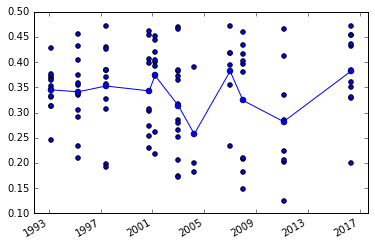

In [494]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['gloom'].values, linestyle='-')

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

fig.autofmt_xdate()
plt.show()

## Complexity per album<a name="complexityovertime"></a>
Let's generate the same plots for "complexity" per album.

* [Top](#top)

In [495]:
pipeline = [
    {'$match': {'gloom': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_complexity': {'$avg': '$complexity'}}}]
album_complexities = collections.defaultdict(int, {a['_id']: a['avg_complexity'] for a in tracks.aggregate(pipeline)})
album_complexities

defaultdict(int,
            {'03Qh833fEdVT30Pfs93ea6': 0.30313780757650094,
             '0PYyrqs9NXtxPhf0CZkq2L': 0.39554610177908917,
             '19K3IHYeVkUTjcBHGfbCOi': 0.4926787306023092,
             '19RUXBFyM4PpmrLRdtqWbp': 0.19682403824100217,
             '1DBkJIEoeHrTX4WCBQGcCi': 0.23682091199666255,
             '1PULmKbHeOqlkIwcDMNwD4': 0.33137519763673373,
             '1oW3v5Har9mvXnGk0x4fHm': 0.2989840032500176,
             '2Pqkn9Dq2DFtdfkKAeqgMd': 0.2801541309531463,
             '2pCqZLeavM2BMovJXsJEIV': 0.35466432570637396,
             '36lJLPoPPOKNFddTAcirnc': 0.17041628698527087,
             '3OdI6e43crvyAHhaqpxSyz': 0.44772169900647624,
             '3nkEsxmIX0zRNXGAexaHAn': 0.5788171236704196,
             '47bcKzmKgmMPHXNVOWpLiu': 0.2953681657492741,
             '500FEaUzn8lN9zWFyZG5C2': 0.2361303334346605,
             '5XfJmldgWzrc1AIdbBaVZn': 0.3887292504282335,
             '5ju5Ouzan3QwXqQt1Tihbh': 0.40349206426460227,
             '6400dnyeDyD2mIFH

In [496]:
albums_df['complexity'] = albums_df['_id'].apply(lambda i: album_complexities[i])
beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]
albums_df.head()

,_id,artist_name,name,release_date,gloom,complexity
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.178420,0.479161
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.150023,0.578817
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.215407,0.549011
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.175109,0.508739
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.220622,0.492679


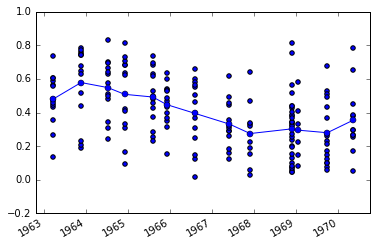

In [497]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

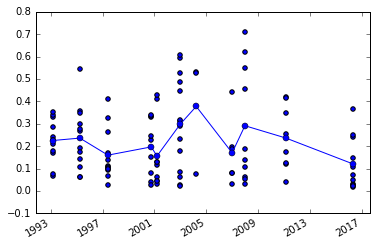

In [498]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

That isn't what I was expecting. I was expecting the complexity to go up over time, as bands became more adept at contrasting lyrics and melody. It could be because high complexity requires high valence, and bands tend not to become more "poppy" over time.

Let's test that, by also showing the valence of tracks and albums over time.

In [499]:
pipeline = [
    {'$match': {'valence': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_valence': {'$avg': '$valence'}}}]
album_valences = collections.defaultdict(int, {a['_id']: a['avg_valence'] for a in tracks.aggregate(pipeline)})
albums_df['valence'] = albums_df['_id'].apply(lambda i: album_valences[i])
beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]

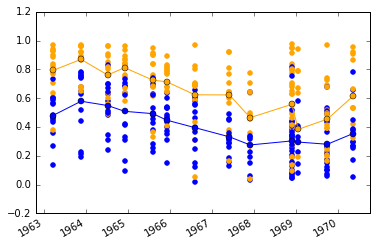

In [500]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(beatles_df['release_date'].values, beatles_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

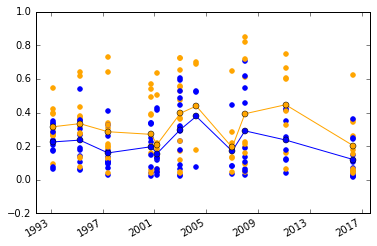

In [501]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

It definitely looks like the Beatles changed style over time, with the _White Ablum_ / _Yellow Submarine_ (around 1969) being a glitch in the trend. _Hail to the Thief_ and _Com Lag_ are unusual albums for Radiohead.

# Conclusion<a name="conclusion"></a>
A couple of things have come out of this. 

One is that the original analysis is very sensitive to how the sentiment of lyrics is determined. That means I'm not too confident about the reliability of results from either fitteR-happieR or this notebook.

Another is that the Beatles are undoubtedly better than Radiohead. The happiest Beatles sonds are happier than anything Radiohead have done, and their saddest songs are about as sad as Radiohead. In just about every measure, the Beatles' range of music is larger, and covers, Radiohead's.

QED.

## Next steps
The obvious next step is to analyse a different group. What would Queen or ELO look like? Is Adele more depressing than Radiohead?

Another approach would be to apply some machine learning / data mining techniques, perhaps to train a better sentiment analyser, or to cluster songs into groups. Which songs by different artists are most similar to each other?

* [Top](#top)